In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from PIL import Image
from functools import reduce
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [3]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/0/'
train_files = [f for f in os.listdir(train_dir) if not f.startswith('.')]
val_dir = './data/FlagsMashupBot/autoencoder_images/val/0/'
val_files = [f for f in os.listdir(val_dir) if not f.startswith('.')]
test_dir = './data/FlagsMashupBot/autoencoder_images/test/0/'
test_files = [f for f in os.listdir(test_dir) if not f.startswith('.')]

In [4]:
len(train_files), len(val_files), len(test_files)

(3440, 737, 738)

In [5]:
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [6]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/'
val_dir = './data/FlagsMashupBot/autoencoder_images/val/'
test_dir = './data/FlagsMashupBot/autoencoder_images/test/'
image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(
    train_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
val_data_gen = image_generator.flow_from_directory(
    val_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')
test_data_gen = image_generator.flow_from_directory(
    test_dir, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    class_mode='input')

Found 3440 images belonging to 1 classes.
Found 737 images belonging to 1 classes.
Found 738 images belonging to 1 classes.


In [7]:
im_test = image_generator

In [8]:
a = next(train_data_gen)

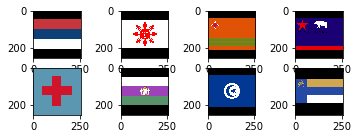

In [9]:
plt.figure()
for i in range(BATCH_SIZE):
    plt.subplot(BATCH_SIZE/2, BATCH_SIZE/2, i+1)
    plt.imshow(a[0][i])

In [10]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT

In [11]:
input_img = Input(shape=(img_width, img_height, 3))

In [12]:
input_img

<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>

In [13]:
conv_shape = (3, 3)

In [14]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [15]:
encoded

<tf.Tensor 'max_pooling2d_2/Identity:0' shape=(None, 32, 32, 8) dtype=float32>

In [16]:
# encoded_flat = Flatten()(encoded)
# lattent_flat = Dense(100, activation='relu')(encoded_flat)
# recoded_flat = Dense(encoded_flat.shape[1], activation='relu')(lattent_flat)
# recoded_3d = Reshape(np.asarray(encoded.shape[1:]))(recoded_flat)

In [17]:
# x = Conv2D(8, conv_shape, activation='relu', padding='same')(recoded_3d)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, conv_shape, activation='sigmoid', padding='same')(x)

In [18]:
decoded

<tf.Tensor 'conv2d_6/Identity:0' shape=(None, 256, 256, 3) dtype=float32>

dimensionality reduction

In [19]:
IMG_HEIGHT * IMG_WIDTH / (reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

8.0

In [20]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0     

In [21]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [22]:
autoencoder_train = autoencoder.fit(
    train_data_gen, 
    epochs=600, 
    shuffle=True,
    validation_data=val_data_gen,
    callbacks=cb)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 430 steps, validate for 93 steps
Epoch 1/600
430/430 [==============================] - 13s 31ms/step - loss: 0.1949 - val_loss: 0.1923
Epoch 2/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1943 - val_loss: 0.1916
Epoch 3/600
430/430 [==============================] - 11s 24ms/step - loss: 0.1935 - val_loss: 0.1908
Epoch 4/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1926 - val_loss: 0.1899
Epoch 5/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1916 - val_loss: 0.1889
Epoch 6/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1905 - val_loss: 0.1878
Epoch 7/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1894 - val_loss: 0.1866
Epoch 8/600
430/430 [==============================] - 11s 24ms/step - loss: 0.1882 - val_loss: 0.1854
Epoch 9/600
430/430 [==============================] - 11s 25ms/step - loss: 0.1869

Epoch 90/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0444 - val_loss: 0.0442
Epoch 91/600
429/430 [============================>.] - ETA: 0s - loss: 0.0442

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



430/430 [==============================] - 11s 25ms/step - loss: 0.0383 - val_loss: 0.0381
Epoch 121/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0380 - val_loss: 0.0379
Epoch 122/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0378 - val_loss: 0.0377
Epoch 123/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0376 - val_loss: 0.0374
Epoch 124/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0374 - val_loss: 0.0372
Epoch 125/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0372 - val_loss: 0.0370
Epoch 126/600
430/430 [==============================] - 10s 24ms/step - loss: 0.0370 - val_loss: 0.0368
Epoch 127/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0367 - val_loss: 0.0365
Epoch 128/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0365 - val_loss: 0.0363
Epoch 129/600
430/430 [==============================] - 10s 24ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



430/430 [==============================] - 11s 25ms/step - loss: 0.0273 - val_loss: 0.0272
Epoch 173/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0272 - val_loss: 0.0270
Epoch 174/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0270 - val_loss: 0.0269
Epoch 175/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0269 - val_loss: 0.0268
Epoch 176/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0268 - val_loss: 0.0266
Epoch 177/600
430/430 [==============================] - 11s 24ms/step - loss: 0.0266 - val_loss: 0.0265
Epoch 178/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0265 - val_loss: 0.0264
Epoch 179/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0264 - val_loss: 0.0262
Epoch 180/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0263 - val_loss: 0.0261
Epoch 181/600
430/430 [==============================] - 11s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



430/430 [==============================] - 11s 25ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 198/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0245 - val_loss: 0.0244
Epoch 199/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0244 - val_loss: 0.0243
Epoch 200/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 201/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0243 - val_loss: 0.0241
Epoch 202/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0242 - val_loss: 0.0241
Epoch 203/600
430/430 [==============================] - 10s 24ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 204/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0240 - val_loss: 0.0239
Epoch 206/600
430/430 [==============================] - 10s 24ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 207/600
430/430 [==============================] - 11s 25ms/ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



430/430 [==============================] - 11s 25ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 320/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 321/600
430/430 [==============================] - 10s 24ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 322/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 326/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 327/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 328/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 329/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 330/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 331/600
430/430 [==============================] - 11s 25ms/ste

430/430 [==============================] - 11s 25ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 479/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 480/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 481/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 482/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 483/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 484/600
430/430 [==============================] - 10s 24ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 485/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 486/600
430/430 [==============================] - 11s 25ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 487/600
430/430 [==============================] - 11s 25ms/ste

In [23]:
# autoencoder.save('./128_model.hdf5')

In [24]:
saved = False
if not saved:
    autoencoder.save('./256_model.hdf5')
    saved = True

In [25]:
test_images_set = next(test_data_gen)[0]

In [26]:
pred = autoencoder.predict(test_images_set)

In [27]:
pred.shape

(8, 256, 256, 3)

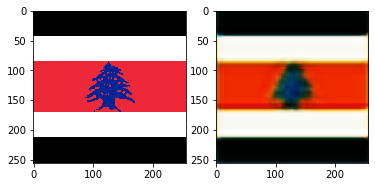

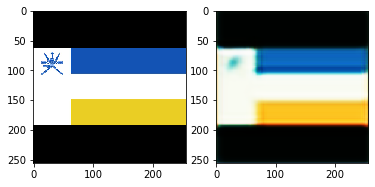

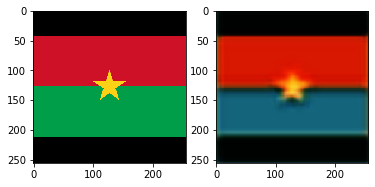

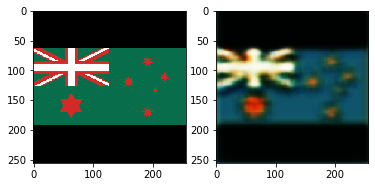

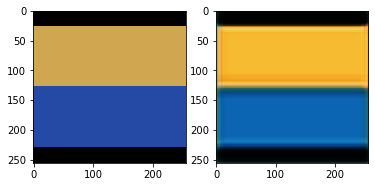

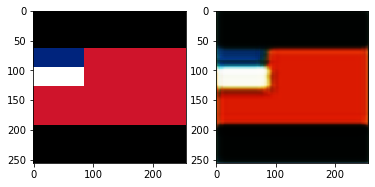

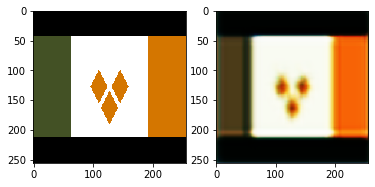

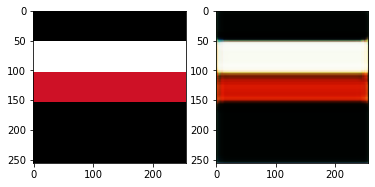

In [28]:
for tr_im, pr_im in zip(test_images_set, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tr_im)
    plt.subplot(1,2,2)
    plt.imshow(pr_im)    

In [29]:
test_im = Image.open('./data/FlagsMashupBot/reals_square_png/arg.png').convert('RGB')
test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
test_ar = np.asarray(test_im) / 255
test_ar = np.expand_dims(test_ar,0)

In [30]:
pred = autoencoder_train.model.predict(test_ar)

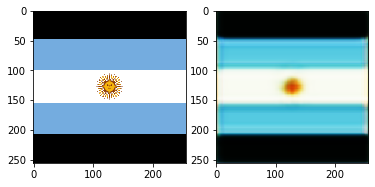

In [31]:
for real, coded in zip(test_ar, pred):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(real)
    plt.subplot(1,2,2)
    plt.imshow(coded)    

### Latent space representation
https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

In [47]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)

In [33]:
info = requests.get('https://restcountries.eu/rest/v2/all')
info = pd.DataFrame(info.json())

In [34]:
latent_model = Model(input_img, encoded)

In [35]:
latent_path = './data/FlagsMashupBot/reals_square_png/'
latent_files = [f for f in os.listdir(latent_path) if f.endswith('.png')]

In [36]:
latent_flags = pd.DataFrame()
for f in latent_files:
    test_im = Image.open(latent_path + f).convert('RGB')
    test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
    test_ar = np.asarray(test_im) / 255
    test_ar_exp = np.expand_dims(test_ar,0)

    latent_pred = latent_model.predict(test_ar_exp)
    code = f.split('.')[0].upper()
    country_info = info[info.alpha3Code == code].iloc[0]
    one = {
        'code': code, 
        'name': country_info.name, 
        'file': f, 
        '3d_latent': np.squeeze(latent_pred[0, :, :, :]),
        '1d_latent': np.ravel(np.squeeze(latent_pred[0, :, :, :])),
        '3d_real': test_ar}
    country_df = pd.DataFrame([one], index = [0])
    latent_flags = latent_flags.append(country_df, ignore_index=True)

In [42]:
from sklearn.manifold import TSNE

In [54]:
latent_tsne = TSNE(n_components=2, random_state=18).fit_transform(np.vstack(latent_flags['1d_latent'].values))

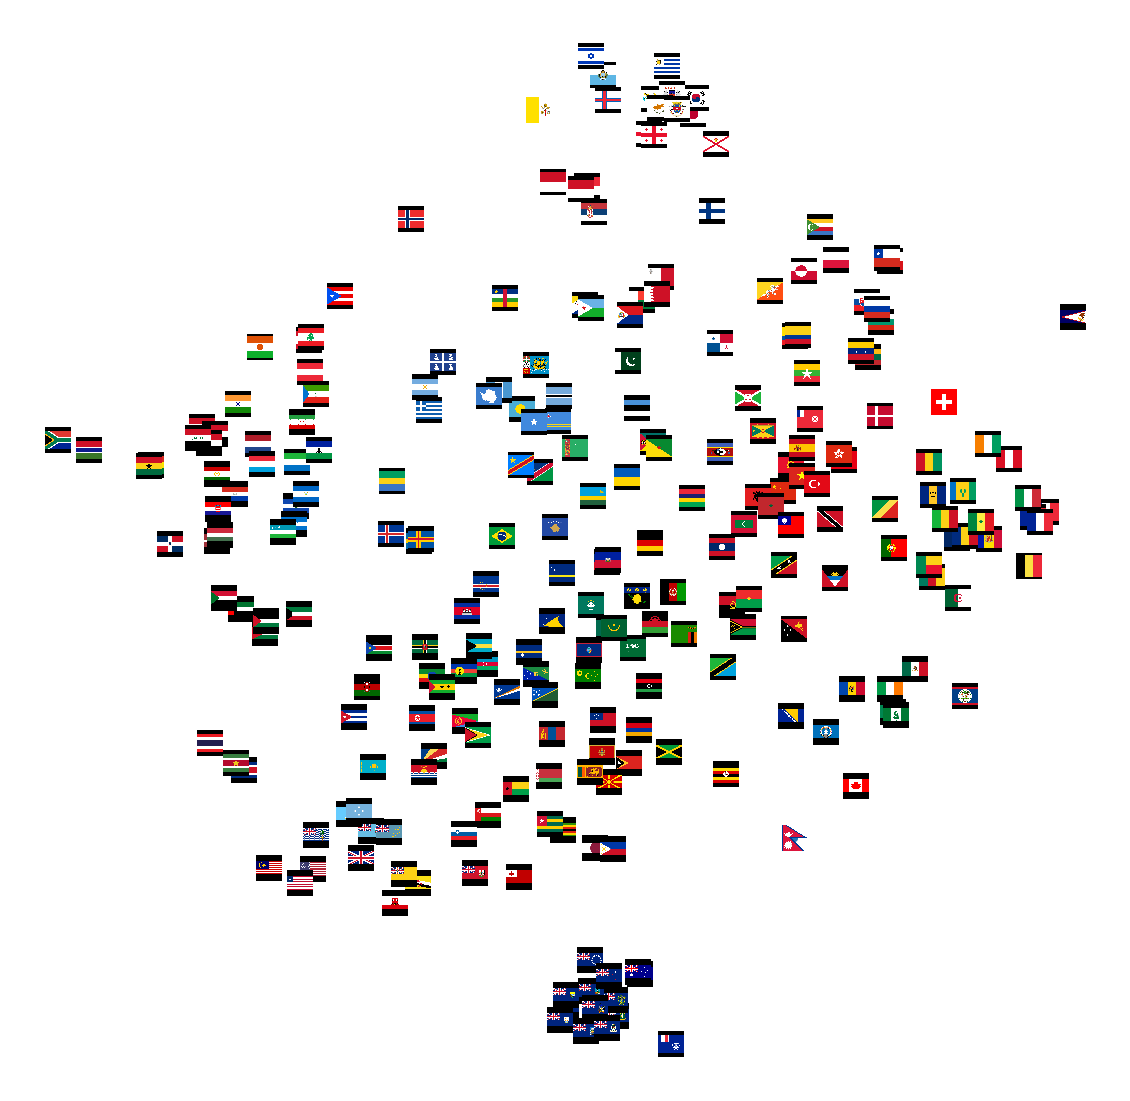

In [66]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
for x0, y0, file in zip(latent_tsne[:, 0], latent_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.axis('off')
plt.tight_layout()
plt.savefig('./tsne_latent.png')
    

In [56]:
real_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(np.vstack([np.ravel(val3d) for val3d in latent_flags['3d_real'].values]))

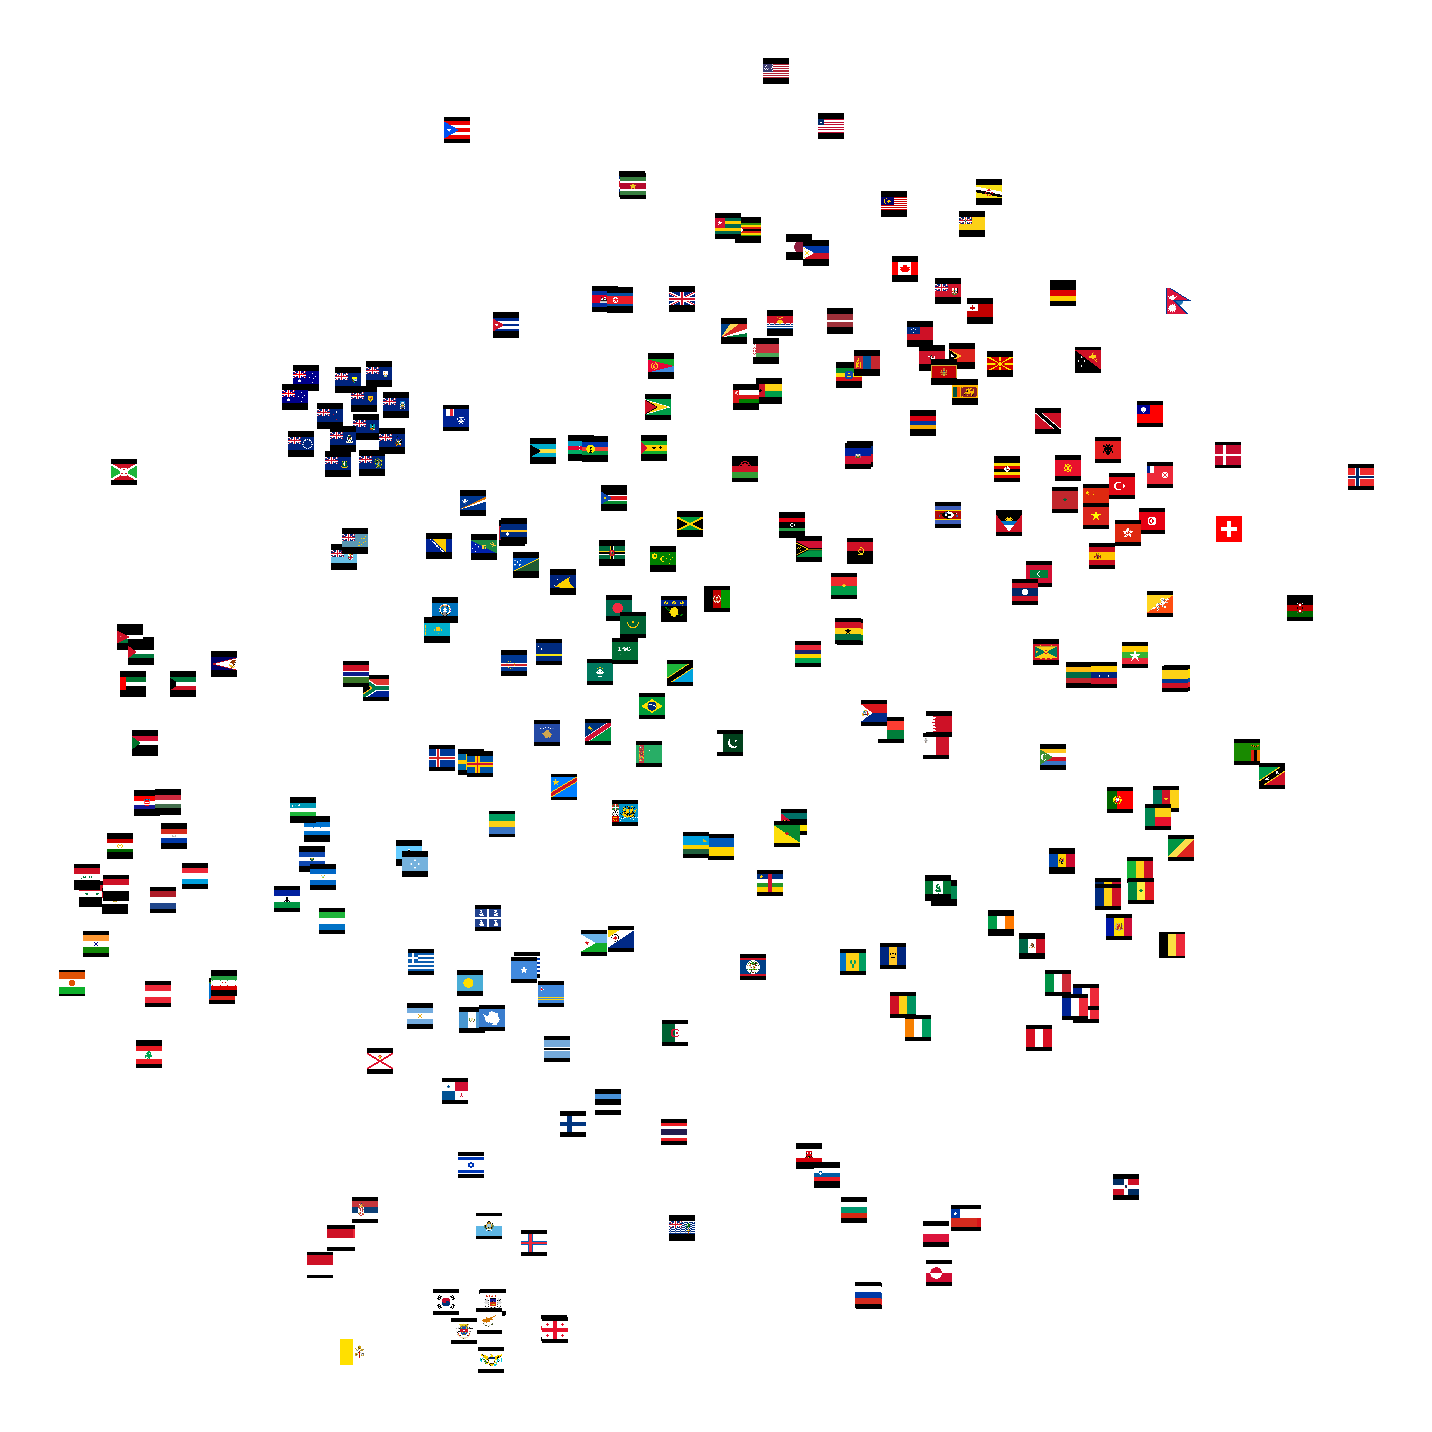

In [67]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(real_tsne[:, 0], real_tsne[:, 1])
for x0, y0, file in zip(real_tsne[:, 0], real_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
# ax.set_facecolor('xkcd:black')
plt.axis('off')
plt.tight_layout()
plt.savefig('./tsne_real.png')